<a href="https://colab.research.google.com/github/Sam74012/Pest_detection_model_on_ip102_dataset/blob/main/Pest_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

path = kagglehub.dataset_download("rtlmhjbn/ip02-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.94G/2.94G [01:23<00:00, 38.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rtlmhjbn/ip02-dataset/versions/1


In [ ]:
import os
from pathlib import Path

def get_dataset_path():
    kaggle_input = "/kaggle/input/ip02-dataset"
    kaggle_cache = "/root/.cache/kagglehub/datasets/rtlmhjbn/ip02-dataset/versions/1"

    if os.path.exists(kaggle_input) and os.listdir(kaggle_input):
        return kaggle_input
    elif os.path.exists(kaggle_cache) and os.listdir(kaggle_cache):
        return kaggle_cache
    else:
        raise FileNotFoundError("❌ Dataset not found in Kaggle input or cache")

# Use dataset path
data_path = get_dataset_path()
print("✅ Using dataset from:", data_path)

# Example usage: list files
print("Files:", os.listdir(data_path))
data_path=Path(data_path)

✅ Using dataset from: /root/.cache/kagglehub/datasets/rtlmhjbn/ip02-dataset/versions/1
Files: ['val.txt', 'train.txt', 'test.txt', 'classification', 'classes.txt']


In [ ]:
import re
pest_list = []
classes_path=data_path / "classes.txt"
with open(classes_path, "r") as f:
  content=f.read()
  for line in content.splitlines():
    match = re.match(r'^\s*\d+\s+(.+?)\s*$', line)
    if match:
      pest_name = match[1].strip()
      if pest_name:
        pest_list.append(pest_name)

In [ ]:
len(pest_list)

102

In [ ]:
pest_list[0]

'rice leaf roller'

In [ ]:
pest_list[21]

'red spider'

In [ ]:
image_path=data_path / "classification"
train_dir=image_path / "train"
test_dir=image_path / "test"
val_dir=image_path / "val"
train_dir, test_dir, val_dir

(PosixPath('/root/.cache/kagglehub/datasets/rtlmhjbn/ip02-dataset/versions/1/classification/train'),
 PosixPath('/root/.cache/kagglehub/datasets/rtlmhjbn/ip02-dataset/versions/1/classification/test'),
 PosixPath('/root/.cache/kagglehub/datasets/rtlmhjbn/ip02-dataset/versions/1/classification/val'))

In [1]:
import torch
import torchvision
from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular/going_modular .
    !mv pytorch-deep-learning/helper_functions.py .
    !rm -rf pytorch-deep-learning
    from going_modular import data_setup, engine
    from helper_functions import plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 21.24 MiB/s, done.
Resolving deltas: 100% (2656/2656), done.
Updating files: 100% (248/248), done.


In [ ]:
eff_transform=torchvision.models.EfficientNet_B0_Weights.DEFAULT.transforms()
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.IMAGENET),
    eff_transform
])

val_transforms=eff_transform

train_transforms, val_transforms

(Compose(
     RandomHorizontalFlip(p=0.5)
     AutoAugment(policy=AutoAugmentPolicy.IMAGENET, fill=None)
     ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 )
 ),
 ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ))

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

NUM_WORKERS=os.cpu_count()
BATCH_SIZE=32

train_dataset = ImageFolder(train_dir, transform=train_transforms)
val_dataset   = ImageFolder(val_dir,   transform=val_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

In [ ]:
test_dataset=ImageFolder(test_dir, transform=val_transforms)
test_dataloader=DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

In [ ]:
len(test_dataloader)

707

In [ ]:
len(train_dataloader), len(val_dataloader)

(1410, 235)

In [ ]:
image, label=next(iter(train_dataloader))

In [ ]:
image.shape

torch.Size([32, 3, 224, 224])

In [ ]:
label.shape

torch.Size([32])

In [ ]:
image[0], label[0]

(tensor([[[ 0.3823,  0.3309,  0.3138,  ..., -1.9124, -1.9980, -1.9124],
          [ 0.3309,  0.3309,  0.3481,  ..., -1.9467, -1.9124, -1.9467],
          [ 0.3309,  0.3652,  0.3994,  ..., -2.0152, -2.0152, -2.0665],
          ...,
          [ 1.1015, -0.2513,  0.5536,  ..., -0.7308, -0.9877, -1.0904],
          [ 0.3138,  1.2899,  0.8276,  ..., -0.2856, -0.7137, -0.8164],
          [-0.6794,  1.2214,  0.9817,  ..., -0.0972, -0.4397, -0.5082]],
 
         [[-1.1604, -1.1779, -1.1604,  ..., -1.3354, -1.4580, -1.3880],
          [-1.0903, -1.1429, -1.1604,  ..., -1.2654, -1.2129, -1.2829],
          [-1.1429, -1.1604, -1.1954,  ..., -1.2129, -1.2479, -1.3354],
          ...,
          [-1.4755, -1.6331,  0.2052,  ...,  0.3452,  0.0826, -0.0049],
          [-1.5980, -1.4755, -1.4055,  ...,  0.7829,  0.3452,  0.2577],
          [-1.7031, -1.6331, -1.4230,  ...,  0.9580,  0.6254,  0.5553]],
 
         [[-1.6127, -1.6127, -1.5779,  ...,  0.4788,  0.3393,  0.2871],
          [-1.4210, -1.4733,

Text(0.5, 1.0, 'paddy stem maggot')

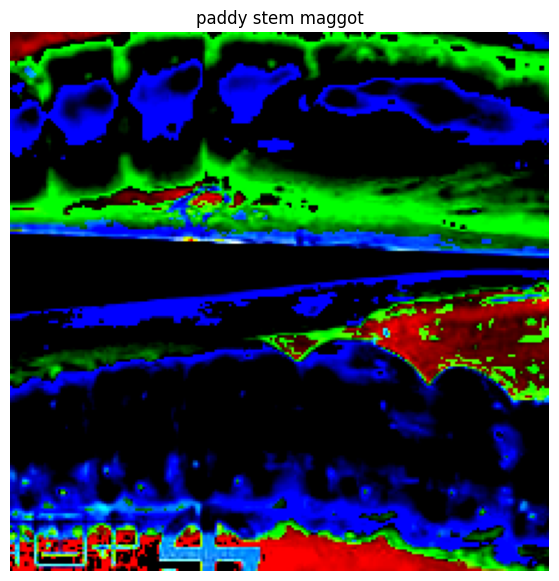

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.imshow(image[0].permute(1, 2, 0))
plt.axis(False)
plt.title(pest_list[label[0]])

In [2]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [3]:
model=torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 154MB/s]


In [4]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [5]:
for param in model.features.parameters():
  param.requires_grad=False

for block in model.features[-4:]:  # last 1 blocks
  for param in block.parameters():
      param.requires_grad = True

In [7]:
output_shape=102

model.classifier=nn.Sequential(
    nn.Dropout(p=0.4, inplace=True),
    nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)
).to(device)

In [8]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 102]            --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   Partial
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32

In [9]:
loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW([
    {'params': model.features[-1].parameters(), 'lr': 3e-5},  # last blocks
    {'params': model.features[-2].parameters(), 'lr': 3e-5},  # last blocks
    {'params': model.features[-3].parameters(), 'lr': 2e-5},  # last blocks
    {'params': model.features[-4].parameters(), 'lr': 1e-5},  # last blocks
    {'params': model.classifier.parameters(), 'lr': 5e-5}      # classifier
], weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=15, T_mult=2)

In [10]:
def save_checkpoint(model, optimizer, epoch, results, path):
  checkpoint = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        # store full history lists
        "train_loss": results["train_loss"],
        "val_loss": results["val_loss"],
        "train_acc": results["train_acc"],
        "val_acc": results["val_acc"]
  }
  torch.save(checkpoint, path)
  print(f"Saved checkpoint at epoch {epoch} -> {path}")

In [11]:
def load_checkpoint(path, model, optimizer, device):
  checkpoint = torch.load(path, map_location=device)
  model.load_state_dict(checkpoint["model_state"], strict=False)
  if optimizer is not None:
    optimizer.load_state_dict(checkpoint["optimizer_state"])
  start_epoch = checkpoint["epoch"] + 1

  results = {
      "train_loss": checkpoint["train_loss"],
      "val_loss": checkpoint["val_loss"],
      "train_acc": checkpoint["train_acc"],
      "val_acc": checkpoint["val_acc"],
  }

  print(f"Loaded checkpoint (epoch {checkpoint['epoch']}). Resuming at epoch {start_epoch}")
  return model, optimizer, start_epoch, results

In [13]:
import os

# --- Mount Google Drive ---
from google.colab import drive
drive.mount("/content/drive")

# --- Setup checkpoint directory ---
checkpoint_dir = "/content/drive/MyDrive/ModelCheckpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

print(f"✅ Drive mounted and checkpoint directory ready: {checkpoint_dir}")

Mounted at /content/drive
✅ Drive mounted and checkpoint directory ready: /content/drive/MyDrive/ModelCheckpoints


In [ ]:
from tqdm.auto import tqdm
from timeit import default_timer as timer
results = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

# Resume from latest checkpoint if exists
import glob

# Find latest checkpoint
checkpoint_files = sorted(glob.glob(os.path.join(checkpoint_dir, "epoch_*.pth")))
if checkpoint_files:
  latest_checkpoint = checkpoint_files[-1]
  model, optimizer, start_epoch, results = load_checkpoint(latest_checkpoint, model, optimizer, device)
else:
  print("No checkpoint found, starting from scratch.")
  start_epoch = 0

start_time = timer()

# Train for remaining epochs
for epoch in tqdm(range(start_epoch, start_epoch+2)):
  train_loss, train_acc = engine.train_step(model, train_dataloader, loss_fn, optimizer, device)
  val_loss, val_acc = engine.test_step(model, val_dataloader, loss_fn, device)

  print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"val_loss: {val_loss:.4f} | "
          f"val_acc: {val_acc:.4f}"
        )

  results["train_loss"].append(train_loss)
  results["train_acc"].append(train_acc)
  results["val_loss"].append(val_loss)
  results["val_acc"].append(val_acc)

  # Save every epoch
  save_checkpoint(
    model, optimizer, epoch, results,
    os.path.join(checkpoint_dir, f"epoch_{epoch}.pth")
  )

  scheduler.step()

end_time = timer()
print(f"[INFO] Training finished in {end_time - start_time:.2f} sec")

Loaded checkpoint (epoch 99). Resuming at epoch 100


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 101 | train_loss: 1.5608 | train_acc: 0.7960 | val_loss: 1.9094 | val_acc: 0.7158
Saved checkpoint at epoch 100 -> /content/drive/MyDrive/ModelCheckpoints/epoch_100.pth
Epoch: 102 | train_loss: 1.5221 | train_acc: 0.8102 | val_loss: 1.8931 | val_acc: 0.7143
Saved checkpoint at epoch 101 -> /content/drive/MyDrive/ModelCheckpoints/epoch_101.pth
[INFO] Training finished in 876.08 sec


In [14]:
from pathlib import Path
model, optimizer, start_epoch, results=load_checkpoint(Path("/content/drive/MyDrive/ModelCheckpoints/epoch_84.pth"),model, optimizer, device)
results["val_acc"][-1], results["val_loss"][-1]

Loaded checkpoint (epoch 84). Resuming at epoch 85


(0.7160904255319149, 1.2356703552239119)

In [26]:
import matplotlib.pyplot as plt
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    val_loss = results["val_loss"]

    accuracy = results["train_acc"]
    val_accuracy = results["val_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

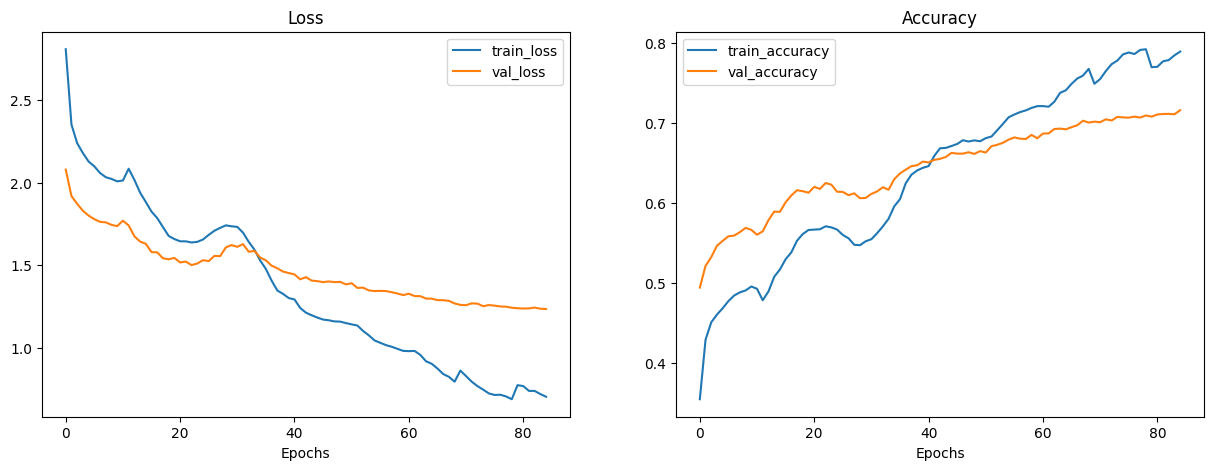

In [27]:
plot_loss_curves(results)

In [16]:
results["train_acc"][-1]

0.7894028622087134

In [17]:
results["train_loss"][-1]

0.704408117938549

In [ ]:
from going_modular import utils

models_dir="/content/drive/MyDrive/Models"
os.makedirs(models_dir, exist_ok=True)

utils.save_model(model=model,
                 target_dir=models_dir,
                 model_name="effnetB0_pest_detect.pth")

[INFO] Saving model to: /content/drive/MyDrive/Models/effnetB0_pest_detect.pth


In [ ]:
from tqdm.auto import tqdm
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device):
  loss, acc=0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y=X.to(device), y.to(device)
      y_pred=model(X)
      loss+=loss_fn(y_pred, y).item()
      test_pred_labels=torch.argmax(y_pred, dim=1)
      acc+=((test_pred_labels == y).sum().item()/len(test_pred_labels))

  loss/=len(data_loader)
  acc/=len(data_loader)

  return {
      "model_name": "EffnetB0_pest_detect",
      "model_loss": loss,
      "model_acc": acc
  }

In [ ]:
test_results=eval_model(model=model,
                        data_loader=test_dataloader,
                        loss_fn=loss_fn,
                        device=device)

  0%|          | 0/707 [00:00<?, ?it/s]

In [ ]:
test_results

{'model_name': 'EffnetB0_pest_detect',
 'model_loss': 1.2555369131979723,
 'model_acc': 0.7119054167321494}